In [52]:
import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
#import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.applications import VGG16,VGG19
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from scipy.misc import imread, imresize

In [2]:
def get_im_cv2(path, img_rows, img_cols, color_type=3):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized

In [3]:
def load_train(img_rows, img_cols, color_type=3,num_files_to_read=-1):
    X_train = []
    y_train = []
    
    print('Read train images')
    for j in range(1,4):
        counter = 0
        print('Load folder Type_{}'.format(j))
        path = os.path.join('..', 'input', 'train', 'Type_' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, img_rows, img_cols, color_type)
            X_train.append(np.asarray(img))
            y_train.append(j)
            counter+=1
            if (counter>=num_files_to_read)&(num_files_to_read>0):
                break
    

    return np.array(X_train), np.array(y_train)

In [35]:
def load_test(img_rows, img_cols, color_type=3):
    X_test = []
    
    print('Read test images')
    path = os.path.join('..', 'input', 'test', '*.jpg')
    files = glob.glob(path)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_test.append(img)
            
    return np.array(X_test)

In [5]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [6]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

In [7]:
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)

In [8]:
def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model

In [9]:
img_rows = 224
img_cols = 224
num_samples = -1
read_from_cache = True
color_type_global = 3
if not read_from_cache:
    X_train, y_train = load_train(img_rows,img_cols,3,num_samples)

In [ ]:
cache_data(X_train,'../processed_input/X_train_{}X{}X{}_{}_max_samples'.format(img_rows,img_cols,
                                                                               color_type_global,num_samples))
cache_data(y_train,'../processed_input/y_train_{}_max_samples'.format(num_samples))

In [11]:
X_train = restore_data('../processed_input/X_train_{}X{}X{}_{}_max_samples'.format(img_rows,img_cols,
                                                                               color_type_global,num_samples))
y_train = restore_data('../processed_input/y_train_{}_max_samples'.format(num_samples))

In [12]:
print X_train.shape
print y_train.shape

(1481, 224, 224, 3)
(1481,)


In [25]:
epochs = 30
batch_size = 16

In [28]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model

#model = create_model(img_rows, img_cols, color_type_global)
# Generate a model with all layers (with top)
vgg16 = VGG16(weights='imagenet', include_top=True)

#Add a layer where input is the output of the  second last layer 
x = (vgg16.layers[-4].output)

#Then create the corresponding model 
model = Model(inputs=vgg16.input, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [29]:
from keras.utils import to_categorical
from sklearn.metrics import log_loss
import keras.backend as K

sgd = SGD(lr=0.001, decay=1e-5, momentum=0.95, nesterov=True)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.fit(X_train, to_categorical(y_train-1,3),validation_split=0.2,shuffle=True, batch_size=batch_size, epochs=epochs, verbose=1)


In [30]:
pred_train = model.predict(X_train)

In [36]:
X_test = load_test(img_cols,img_rows,3)
pred_test = model.predict(X_test)

Read test images


In [37]:
print np.array(pred_train).shape
print np.array(pred_test).shape

(1481, 25088)
(512, 25088)


In [51]:
import xgboost as xgb

params = {'objective':'multi:softprob',
                    'learning_rate':0.1,
                    'subsample':0.2,
                    'colsample_bytree':0.9,
                    'colsample_bylevel':0.7,
                    'max_depth':6,
                    #'lambda_reg':40,
                    'nthread':4,
                    'eval_metric':'mlogloss',
                    'num_class':3,
                    'seed':1234}

bst_cv = xgb.cv(params=params,dtrain=xgb.DMatrix(pred_train,label=y_train-1),verbose_eval=1,
                nfold=5,early_stopping_rounds=20,num_boost_round=300)

[0]	train-mlogloss:1.06134+0.00161076	test-mlogloss:1.07895+0.00321959
[1]	train-mlogloss:1.03019+0.00290676	test-mlogloss:1.0632+0.00512965
[2]	train-mlogloss:1.00099+0.00397196	test-mlogloss:1.05477+0.0111547
[3]	train-mlogloss:0.972201+0.00520244	test-mlogloss:1.03968+0.0135581
[4]	train-mlogloss:0.946308+0.00354334	test-mlogloss:1.02956+0.0161288
[5]	train-mlogloss:0.921097+0.00247161	test-mlogloss:1.02102+0.0156325
[6]	train-mlogloss:0.897349+0.00478486	test-mlogloss:1.01234+0.0179579
[7]	train-mlogloss:0.874715+0.00389237	test-mlogloss:1.00696+0.0179085
[8]	train-mlogloss:0.85446+0.003255	test-mlogloss:0.999694+0.0200941
[9]	train-mlogloss:0.834859+0.00461606	test-mlogloss:0.993182+0.0207088
[10]	train-mlogloss:0.815779+0.00379289	test-mlogloss:0.988465+0.0222464
[11]	train-mlogloss:0.79754+0.0021838	test-mlogloss:0.982192+0.0225475
[12]	train-mlogloss:0.779937+0.002579	test-mlogloss:0.976518+0.0229209
[13]	train-mlogloss:0.763203+0.00239414	test-mlogloss:0.972068+0.0215405
[14]	

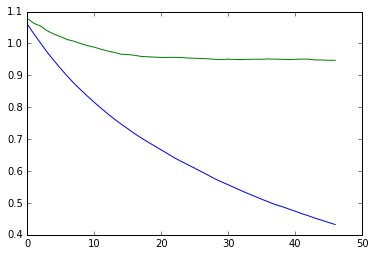

In [53]:
plt.plot(bst_cv.loc[:,['train-mlogloss-mean','test-mlogloss-mean']])
#bst_cv

In [54]:
import xgboost as xgb

params = {'objective':'multi:softprob',
                    'learning_rate':0.025,
                    'subsample':0.2,
                    'colsample_bytree':0.8,
                    'colsample_bylevel':0.7,
                    'max_depth':6,
                    #'lambda_reg':40,
                    'nthread':4,
                    'eval_metric':'mlogloss',
                    'num_class':3,
                    'seed':1234}

bst_cv = xgb.cv(params=params,dtrain=xgb.DMatrix(pred_train,label=y_train-1),verbose_eval=1,
                nfold=5,early_stopping_rounds=20,num_boost_round=300)

[0]	train-mlogloss:1.08902+0.000613253	test-mlogloss:1.09414+0.000947661
[1]	train-mlogloss:1.07977+0.00118328	test-mlogloss:1.08915+0.000761969
[2]	train-mlogloss:1.07051+0.00168653	test-mlogloss:1.08498+0.00100882
[3]	train-mlogloss:1.06227+0.00178805	test-mlogloss:1.08097+0.000631178
[4]	train-mlogloss:1.05379+0.00174761	test-mlogloss:1.07635+0.00108786
[5]	train-mlogloss:1.04547+0.00209409	test-mlogloss:1.07293+0.00231362
[6]	train-mlogloss:1.03732+0.00209033	test-mlogloss:1.06825+0.00251764
[7]	train-mlogloss:1.02926+0.00254526	test-mlogloss:1.0641+0.00374511
[8]	train-mlogloss:1.02098+0.00211214	test-mlogloss:1.0592+0.00326896
[9]	train-mlogloss:1.01314+0.0019626	test-mlogloss:1.05569+0.00369242
[10]	train-mlogloss:1.00561+0.00174674	test-mlogloss:1.05263+0.00432209
[11]	train-mlogloss:0.998014+0.00167718	test-mlogloss:1.04816+0.00530811
[12]	train-mlogloss:0.990903+0.00137529	test-mlogloss:1.04506+0.00528688
[13]	train-mlogloss:0.983661+0.00133368	test-mlogloss:1.04068+0.0051709

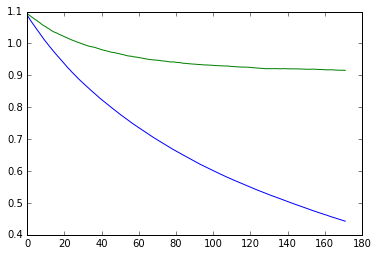

In [55]:
plt.plot(bst_cv.loc[:,['train-mlogloss-mean','test-mlogloss-mean']])
#bst_cv

In [57]:
bst = xgb.train(params=params,dtrain=xgb.DMatrix(pred_train,label=y_train-1),num_boost_round=210)
test_predictions = bst.predict(xgb.DMatrix(pred_test))
subm = pd.DataFrame(test_predictions)
subm


,0,1,2
0,0.182784,0.491907,0.325309
1,0.080652,0.509664,0.409685
2,0.095255,0.585612,0.319132
3,0.137462,0.649402,0.213136
4,0.193163,0.695787,0.111050
5,0.178777,0.654061,0.167162
6,0.041345,0.502550,0.456104
7,0.188911,0.677830,0.133258
8,0.129212,0.777222,0.093566
9,0.032608,0.418263,0.549129


In [60]:
path = os.path.join('..', 'input', 'test', '*.jpg')
files = glob.glob(path)
ids = [x.split('/')[3] for x in files]
ids

['437.jpg',
 '189.jpg',
 '265.jpg',
 '454.jpg',
 '354.jpg',
 '215.jpg',
 '350.jpg',
 '407.jpg',
 '458.jpg',
 '366.jpg',
 '422.jpg',
 '167.jpg',
 '451.jpg',
 '112.jpg',
 '224.jpg',
 '198.jpg',
 '376.jpg',
 '447.jpg',
 '341.jpg',
 '104.jpg',
 '489.jpg',
 '77.jpg',
 '457.jpg',
 '25.jpg',
 '23.jpg',
 '330.jpg',
 '377.jpg',
 '124.jpg',
 '247.jpg',
 '507.jpg',
 '218.jpg',
 '9.jpg',
 '225.jpg',
 '3.jpg',
 '32.jpg',
 '196.jpg',
 '19.jpg',
 '90.jpg',
 '441.jpg',
 '4.jpg',
 '132.jpg',
 '254.jpg',
 '92.jpg',
 '390.jpg',
 '408.jpg',
 '205.jpg',
 '128.jpg',
 '343.jpg',
 '164.jpg',
 '368.jpg',
 '281.jpg',
 '260.jpg',
 '139.jpg',
 '344.jpg',
 '263.jpg',
 '445.jpg',
 '176.jpg',
 '494.jpg',
 '333.jpg',
 '448.jpg',
 '468.jpg',
 '384.jpg',
 '328.jpg',
 '373.jpg',
 '327.jpg',
 '273.jpg',
 '257.jpg',
 '175.jpg',
 '473.jpg',
 '170.jpg',
 '169.jpg',
 '208.jpg',
 '212.jpg',
 '179.jpg',
 '202.jpg',
 '174.jpg',
 '108.jpg',
 '464.jpg',
 '503.jpg',
 '436.jpg',
 '490.jpg',
 '303.jpg',
 '421.jpg',
 '2.jpg',
 '87.jp

In [61]:

subm.columns = ['Type_'+ str(x) for x in range(1,4)]
subm['image_name'] = ids

subm.to_csv('../subm/xgb_over_vgg16_fcn_features.csv',index=False)